In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import matplotlib

from counterfactuals.datasets import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
import torch.utils

from counterfactuals.plot_utils import (
    plot_generative_model_distribution,
    plot_classifier_decision_region,
)

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = MoonsDataset("../data/moons.csv")
# dataset.get_cv_splits(5)

In [4]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="moons_mlp.pt",
# )
disc_model.load("globe-ce-moons/moons_mlp.pt")
disc_model.eval()

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_st

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [5]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == np.argmax(dataset.y_test, axis=1)).mean())

Test accuracy: 0.9951219512195122


In [6]:
dataset.y_train = dataset.y_transformer.transform(
    disc_model.predict(dataset.X_train).detach().numpy().reshape(-1, 1)
)
dataset.y_test = dataset.y_transformer.transform(
    disc_model.predict(dataset.X_test).detach().numpy().reshape(-1, 1)
)

In [7]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=2,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     train_dataloader,
#     learning_rate=1e-3,
#     patience=100,
#     num_epochs=500,
#     checkpoint_path="moons_flow.pth",
# )
gen_model.load("moons_flow1.pth")

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.loa

In [8]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

In [9]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

Xs = pd.read_csv("globe-ce-moons/original_mlp.csv", index_col=0).values
Xs_cfs = pd.read_csv("globe-ce-moons/cfs_mlp.csv", index_col=0).values
# Xs_cfs = Xs_cfs + np.array([0.02, 0.0])

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_25321/45346400.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_25321/45346400.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


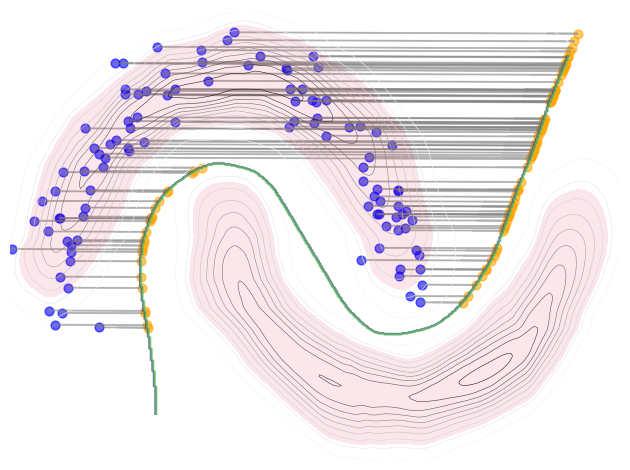

In [10]:
# fig, ax = plt.subplots(figsize=(10, 10))
disc_model.eval()
fig, ax = plt.subplots(1, 1)


# Add arrows between each Xs and Xs_cfs
group_colors = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
xs_group = Xs
xs_cfs_group = Xs_cfs
ax.scatter(
    xs_cfs_group[:, 0],
    xs_cfs_group[:, 1],
    c="orange",
    cmap=matplotlib.colormaps["tab10"],
    s=40,
    alpha=0.6,
)
ax.scatter(
    xs_group[:, 0],
    xs_group[:, 1],
    c=group_colors[0],
    cmap=matplotlib.colormaps["tab10"],
    s=40,
    alpha=0.6,
)
for i in range(len(xs_group)):
    ax.arrow(
        xs_group[i, 0],
        xs_group[i, 1],
        xs_cfs_group[i, 0] - xs_group[i, 0],
        xs_cfs_group[i, 1] - xs_group[i, 1],
        head_width=0.00,
        head_length=-0.05,
        fc="grey",
        ec="grey",
        # fc=group_colors[group_i],
        # ec=group_colors[group_i],
        alpha=0.5,
    )
# for i in range(len(Xs)):
#     ax.arrow(
#         Xs[i, 0],
#         Xs[i, 1],
#         Xs_cfs[i, 0] - Xs[i, 0],
#         Xs_cfs[i, 1] - Xs[i, 1],
#         head_width=0.02,
#         head_length=0.00,
#         fc="gray",
#         ec="gray",
#         alpha=0.5,
# )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# plot_observations(ax, Xs, ys_orig, group_colors)
# plot_counterfactuals(ax, Xs_cfs)
# plot_arrows(ax, Xs, Xs_cfs)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("alt_method_global.pdf", dpi=300)
plt.show()

# Global

In [11]:
Xs_cfs = pd.read_csv("globe-ce-moons/glance_cfs_mlp.csv", index_col=0).values
Xs = pd.read_csv("globe-ce-moons/glance_original_mlp.csv", index_col=0).values

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_25321/1243158728.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_25321/1243158728.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


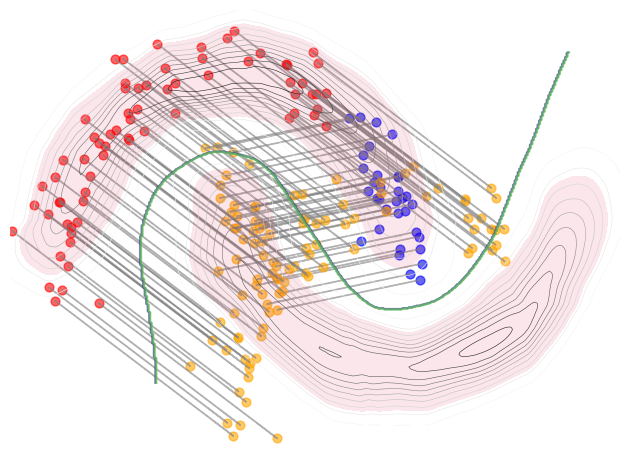

In [12]:
# fig, ax = plt.subplots(figsize=(10, 10))
disc_model.eval()
fig, ax = plt.subplots(1, 1)


# Add arrows between each Xs and Xs_cfs
group_colors = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
xs_group = Xs
xs_cfs_group = Xs_cfs
group_is = np.argmax(Xs - Xs_cfs, axis=1)
for group_i in np.unique(group_is):
    xs_group = Xs[group_is == group_i]
    xs_cfs_group = Xs_cfs[group_is == group_i]
    ax.scatter(
        xs_cfs_group[:, 0],
        xs_cfs_group[:, 1],
        c="orange",
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    ax.scatter(
        xs_group[:, 0],
        xs_group[:, 1],
        c=group_colors[group_i],
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    for i in range(len(xs_group)):
        ax.arrow(
            xs_group[i, 0],
            xs_group[i, 1],
            xs_cfs_group[i, 0] - xs_group[i, 0],
            xs_cfs_group[i, 1] - xs_group[i, 1],
            head_width=0.00,
            head_length=-0.05,
            fc="grey",
            ec="grey",
            # fc=group_colors[group_i],
            # ec=group_colors[group_i],
            alpha=0.5,
        )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# plot_observations(ax, Xs, ys_orig, group_colors)
# plot_counterfactuals(ax, Xs_cfs)
# plot_arrows(ax, Xs, Xs_cfs)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("alt_method_group.pdf", dpi=300)
plt.show()

# LOCAL

In [13]:
import dice_ml

In [14]:
train_dataframe = pd.DataFrame(
    np.concatenate(
        (dataset.X_train, np.argmax(dataset.y_train, axis=1).reshape(-1, 1)), axis=1
    ),
    columns=dataset.features,
)


def __np_to_pd(arr):
    return pd.DataFrame(arr.reshape(1, -1), columns=train_dataframe.columns[:-1])


dice_data = dice_ml.Data(
    dataframe=train_dataframe,
    continuous_features=list(train_dataframe.columns[:-1]),
    outcome_name=train_dataframe.columns[-1],
)
dice_model = dice_ml.Model(model=disc_model, backend="PYT")
dice_exp = dice_ml.Dice(dice_data, dice_model)

In [15]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
Xs_cfs = []
for x in Xs:
    exp = dice_exp.generate_counterfactuals(
        __np_to_pd(x),
        total_CFs=1,
        desired_class=1,
        proximity_weight=0.5,
        verbose=False,
    )
    explanation = exp.cf_examples_list[0].final_cfs_df.to_numpy()[:, :-1]
    Xs_cfs.append(explanation)
Xs_cfs = np.array(Xs_cfs).squeeze()

100%|██████████| 1/1 [00:00<00:00, 28.72it/s]


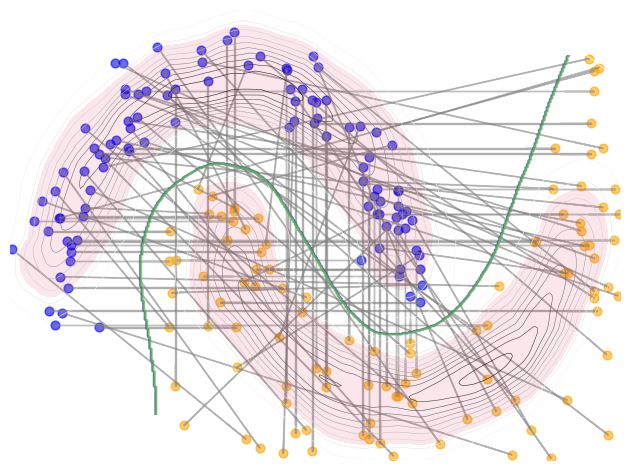

In [19]:
# fig, ax = plt.subplots(figsize=(10, 10))
disc_model.eval()
fig, ax = plt.subplots(1, 1)


# Add arrows between each Xs and Xs_cfs
group_colors = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
xs_group = Xs
xs_cfs_group = Xs_cfs
ax.scatter(
    xs_cfs_group[:, 0],
    xs_cfs_group[:, 1],
    c="orange",
    cmap=matplotlib.colormaps["tab10"],
    s=40,
    alpha=0.6,
)
ax.scatter(
    xs_group[:, 0],
    xs_group[:, 1],
    c=group_colors[0],
    cmap=matplotlib.colormaps["tab10"],
    s=40,
    alpha=0.6,
)
for i in range(len(xs_group)):
    ax.arrow(
        xs_group[i, 0],
        xs_group[i, 1],
        xs_cfs_group[i, 0] - xs_group[i, 0],
        xs_cfs_group[i, 1] - xs_group[i, 1],
        head_width=0.00,
        head_length=-0.05,
        fc="grey",
        ec="grey",
        # fc=group_colors[group_i],
        # ec=group_colors[group_i],
        alpha=0.5,
    )
# for i in range(len(Xs)):
#     ax.arrow(
#         Xs[i, 0],
#         Xs[i, 1],
#         Xs_cfs[i, 0] - Xs[i, 0],
#         Xs_cfs[i, 1] - Xs[i, 1],
#         head_width=0.02,
#         head_length=0.00,
#         fc="gray",
#         ec="gray",
#         alpha=0.5,
# )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# plot_observations(ax, Xs, ys_orig, group_colors)
# plot_counterfactuals(ax, Xs_cfs)
# plot_arrows(ax, Xs, Xs_cfs)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("alt_method_local.pdf", dpi=300)
plt.show()